In [1]:
%pylab inline

#general
import random
import numpy as np
import matplotlib.pyplot as plt

#data set import
from sklearn.datasets import load_breast_cancer

#nureul network imports
from pybrain.tools.shortcuts import buildNetwork

#ga import
from deap import algorithms
from deap import base
from deap import creator
from deap import tools


Populating the interactive namespace from numpy and matplotlib


<p><strong>Data Wrangling</strong></p>
<p>Here we seperate the data out into 100 training cases, equal parts malaginint and benign, and 469 remaining evalulation cases.</p>

In [2]:
data = load_breast_cancer()

data_m = []
data_b = []
for input, output in zip(data["data"],data['target']):
    if output == 0:
        data_m.append((input,output))
    else:
        data_b.append((input,output))

#variable to store number of values to train off of, selected at a 50/50 mix
num_train = 100

train_x = []
train_y = []

eval_x = []
eval_y = []

#populate the training data
for i in range(0,num_train//2):
    train_x.append(data_m[i][0])
    train_x.append(data_b[i][0])
    train_y.append(data_m[i][1])
    train_y.append(data_b[i][1])
    
for item in data_m[num_train//2:]:
    eval_x.append(item[0])
    eval_y.append(item[1])

for item in data_b[num_train//2:]:
    eval_x.append(item[0])
    eval_y.append(item[1])

 <p><strong>Neural Network</strong></p>
<p>Here we initialize our neural network, with 30 inputs, 2 hidden layers, with 15 and 2 nodes respectivly, and 1 output.</p>

In [3]:
net = buildNetwork(30,15,2,1)
LEN_PARAM = len(net.params)

<p><strong>Setup Deap</strong></p>
<p>Here we initialize the properties for an individual and the fitness function. Eeach individual is set to be a random float from -1 to 1</p>

In [4]:
def random_0to1():
    return random.uniform(-1, 1)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random_0to1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=LEN_PARAM)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

<p><strong>Fitness Function</strong></p>
<p>Here we activate the network with the weights given by the genes for every test case in eval X and if the result is &gt;= 0, we have a result of 1, if &lt; 0 we have a 0</p>

In [5]:
def evalNN(individual):
    net._setParameters(individual)
    fitness = 0
    for result, actual in zip(map(net.activate,train_x),train_y):
        if result >= 0 and actual == 0:
            fitness += 1
        elif result < 0 and actual == 1:
            fitness += 1
    return fitness,

toolbox.register("evaluate", evalNN)

In [6]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=5)

<p><strong>Evaluation on all:</strong></p>
<p>This function is used to test an individual against the the datapoints not used to train the network. It returns the number it got wrong.</p>

In [7]:
def evalNNall(individual):
    net._setParameters(individual)
    fitness = 0
    for result, actual in zip(map(net.activate,eval_x),eval_y):
        if result >= 0 and actual == 0:
            fitness += 1
        elif result < 0 and actual == 1:
            fitness += 1
    return fitness

<p><strong>Evolutionary Algorithm</strong></p>
<p> We run a ea(explained below) on a 1000 individuals for 20 generations. The selection method is tournament size of 5. Each gene is mutated with values from a gaussian distribution, with an independent probability of 0.2. The hall of fame stores the fittest individual, across all generations (not just the last)<p>


<p>The documantation for easimple can be found at&nbsp;<a href="https://deap.readthedocs.io/en/master/api/algo.html">https://deap.readthedocs.io/en/master/api/algo.html</a> under easimple. The algorithm is effectively a heavily modified steady state model. I didn't reproduce the the description of the&nbsp;algorithm fully here, since the description there is more helpful, and since DEAP uses specfic functions that I could not explain better then the documantation.</p>

In [14]:
def run_ea():
    
    pop = toolbox.population(n=1000)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=20, stats=stats, halloffame=hof, verbose=True)
    
    return pop, logbook, hof

gen	nevals	avg   	min	max
0  	1000  	49.951	11 	89 
1  	589   	48.83 	11 	85 
2  	565   	45.951	10 	90 
3  	635   	40.781	8  	86 
4  	581   	32.566	7  	92 
5  	589   	27.777	7  	93 
6  	604   	26.592	6  	93 
7  	597   	25.041	6  	92 
8  	610   	22.494	6  	93 
9  	613   	19.985	5  	74 
10 	598   	19.697	5  	93 
11 	606   	18.025	5  	72 
12 	591   	15.284	5  	92 
13 	600   	12.745	5  	88 
14 	599   	10.543	4  	57 
15 	642   	9.835 	4  	51 
16 	601   	10.028	4  	51 
17 	568   	9.895 	4  	51 
18 	583   	8.96  	4  	50 
19 	625   	9.668 	4  	50 
20 	595   	9.005 	4  	50 
Best individual is: [0.22819337833360062, -0.3721778966027123, -0.16836078038794033, -0.9200776155290193, 0.03725596257501329, -0.7831849216618363, -0.3656406406482986, -0.9049222045718082, -0.7737769888259982, -0.6989399449076493, 0.5722235094859482, 0.024941186285468264, 0.6535790810702149, 0.630363668439497, 0.05722563613107745, 0.3131019150752177, 0.5864477921979849, -0.950149709227436, 0.17690471390955076, -0.1966753161

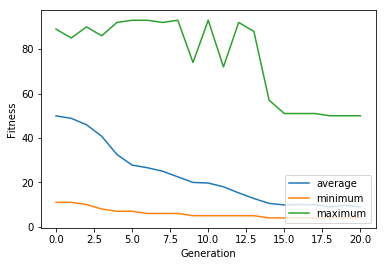

In [18]:
pop, log, hof = run_ea()
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

In [19]:
#number of incorrect results on the values not used in training
print(evalNNall(hof[0]))

40
